In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

In [33]:
pd.set_option("display.max_columns", None)

In [34]:
df = pd.read_csv("../../data/processed/data_train_model.csv")

In [35]:
alcohol = ['Alcohol']

nicotine = ['Nicotine']

illegal_drugs1 = ['Cannabis', 'Legalh', 'LSD', 'Shrooms', 
                  'Amphet', 'Amyl', 'Ecstasy', 'Ketamine', 
                  'Coke']

illegal_drugs2 = ['Meth', 'Benzos', 'Heroin', 'Crack']

In [36]:
borders = [4, 2, 3, 3, 3, 3, 3, 2, 2]
drug_zip = list(zip(borders, illegal_drugs1))

for b, drug in zip(borders, illegal_drugs1):
    df[drug+'_bin'] = [1 if d > b else 0 for d in df[drug].values]

In [37]:
df.iloc[:, -9:].sum(axis=0)

Cannabis_bin    421
Legalh_bin      367
LSD_bin         111
Shrooms_bin     102
Amphet_bin      157
Amyl_bin         29
Ecstasy_bin     170
Ketamine_bin    143
Coke_bin        293
dtype: int64

In [38]:
df['illegal_drugs_1'] = df.iloc[:, -9:].sum(axis=1)

df['illegal_drugs_1'] = [1 if ill > 0 else 0 for ill in df.illegal_drugs_1.values]
df.illegal_drugs_1.value_counts()

1    640
0    617
Name: illegal_drugs_1, dtype: int64

In [10]:
X = df.iloc[:, :12]

In [11]:
y = df.illegal_drugs_1

# Models
- Naive Bayes
- Decision Tree
- Random Forests
- KNN
- Logreg
- SVM
- Assemble Methods (AdaBoost, XGBoost)

# Naive Bayes - Baseline

In [12]:
clf = GaussianNB()
#clf.fit(X, y)

In [13]:
f1_score = cross_val_score(clf, X, y, scoring='f1')
print(f1_score)

[0.76987448 0.82677165 0.81395349 0.83076923 0.80161943]


In [14]:
y_pred_NB_drugs1 = cross_val_predict(clf,X, y, cv=5)

In [15]:
print(classification_report(y, y_pred_NB_drugs1))
print(confusion_matrix(y, y_pred_NB_drugs1))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       617
           1       0.82      0.80      0.81       640

    accuracy                           0.81      1257
   macro avg       0.81      0.81      0.81      1257
weighted avg       0.81      0.81      0.81      1257

[[508 109]
 [131 509]]


## SMOTE Naive Bayes

In [16]:
df.illegal_drugs_1.value_counts()/df.shape[0]

1    0.509149
0    0.490851
Name: illegal_drugs_1, dtype: float64

In [17]:
Counter(y)

Counter({0: 617, 1: 640})

In [18]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

In [19]:
clf = GaussianNB()

In [20]:
y_pred_NB_drugs1_smote = cross_val_predict(clf,X_smote, y_smote, cv=5)

In [21]:
print(classification_report(y_smote, y_pred_NB_drugs1_smote))
print(confusion_matrix(y_smote, y_pred_NB_drugs1_smote))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       640
           1       0.83      0.80      0.81       640

    accuracy                           0.82      1280
   macro avg       0.82      0.82      0.82      1280
weighted avg       0.82      0.82      0.82      1280

[[532 108]
 [126 514]]


# Decision Tree

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       640
           1       0.76      0.74      0.75       640

    accuracy                           0.75      1280
   macro avg       0.75      0.75      0.75      1280
weighted avg       0.75      0.75      0.75      1280



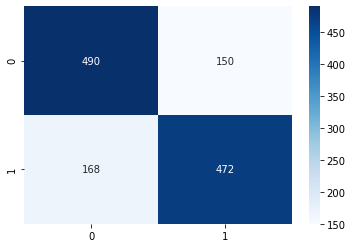

In [22]:
dtree = DecisionTreeClassifier(max_depth=10)
y_pred_drugs1_dt = cross_val_predict(dtree, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_dt)
print(classification_report(y_smote, y_pred_drugs1_dt))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

# Random Forest

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       640
           1       0.83      0.82      0.83       640

    accuracy                           0.83      1280
   macro avg       0.83      0.83      0.83      1280
weighted avg       0.83      0.83      0.83      1280



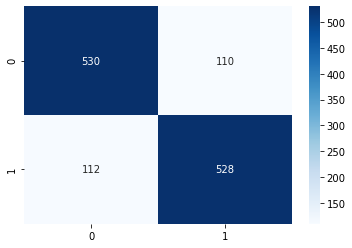

In [23]:
rf = RandomForestClassifier(n_estimators = 200, random_state=10)#, class_weight="balanced")
y_pred_drugs1_rf = cross_val_predict(rf, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_rf)
print(classification_report(y_smote, y_pred_drugs1_rf))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

In [30]:
parameters = { 
    'n_estimators': [200, 500, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,50,1000],
    'criterion' :['gini', 'entropy']
}

scorer = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']
grid_rnc = GridSearchCV(rf, parameters,scoring=scorer, refit='f1') 
grid_rnc.fit(X_smote,y_smote) 
best_rnc = grid_rnc.best_estimator_ 
best_scores = grid_rnc.cv_results_
best_param = grid_rnc.best_estimator_

In [32]:
grid_rnc.best_score_

0.829464979137617

# Logistische Regression

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       639
           1       0.84      0.79      0.81       639

    accuracy                           0.82      1278
   macro avg       0.82      0.82      0.82      1278
weighted avg       0.82      0.82      0.82      1278



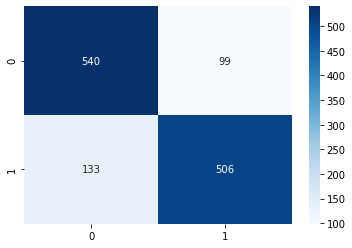

In [439]:
logreg = LogisticRegression(max_iter=1000, solver="liblinear")
y_pred_drugs1_lr = cross_val_predict(logreg, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_lr)
print(classification_report(y_smote, y_pred_drugs1_lr))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

#  KNN

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       639
           1       0.85      0.74      0.79       639

    accuracy                           0.81      1278
   macro avg       0.81      0.81      0.80      1278
weighted avg       0.81      0.81      0.80      1278



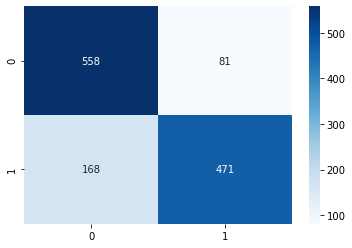

In [440]:
knn = KNeighborsClassifier(n_neighbors=8)
y_pred_drugs1_knn = cross_val_predict(knn, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_knn)
print(classification_report(y_smote, y_pred_drugs1_knn))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

# Support Vector Machines

In [441]:
sv = svm.SVC(kernel='rbf')

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       639
           1       0.82      0.80      0.81       639

    accuracy                           0.81      1278
   macro avg       0.81      0.81      0.81      1278
weighted avg       0.81      0.81      0.81      1278



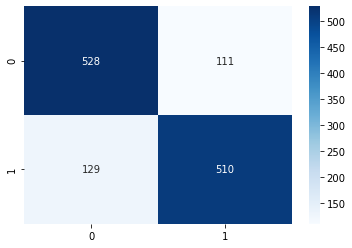

In [442]:
y_pred_drugs1_svm = cross_val_predict(sv, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_svm)
print(classification_report(y_smote, y_pred_drugs1_svm))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

# XG Boost

In [29]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
y_pred_drugs1_XG = cross_val_predict(xgb, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_XG)
print(classification_report(y_smote, y_pred_drugs1_XG))
print(cm)

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       640
           1       0.81      0.80      0.80       640

    accuracy                           0.80      1280
   macro avg       0.80      0.80      0.80      1280
weighted avg       0.80      0.80      0.80      1280

[[518 122]
 [129 511]]


# AdaBoost

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state = 101)
y_pred_ada = cross_val_predict(ada, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_ada)
print(classification_report(y_smote, y_pred_ada))
print(cm)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       640
           1       0.83      0.80      0.81       640

    accuracy                           0.82      1280
   macro avg       0.82      0.82      0.82      1280
weighted avg       0.82      0.82      0.82      1280

[[534 106]
 [129 511]]


# F1 beta score, weighting of parameters, feature selection

# Evaluation

In [ ]:
test = pd.read_csv('../../data/processed/data_test_model.csv')